# <center> Creating Investiment Strategies with Machine Learning Algorithms</center>

## <center>Programming Session 7 - Temporal Processing using RNNs and Transformers -
</center>
<center>
<table class="tfo-notebook-buttons" style="margin-left: auto; margin-right: auto;">
  <tr>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://colab.research.google.com/drive/1nnX88vG1N1-pG5Hon9UcYvEU4mQbnVyY?usp=sharing">
        <img src="https://drive.google.com/uc?export=view&id=1gmxxmwCR1WXK0IYtNqvE4QXFleznWqQO" height="50"/>
        <br>Course page
      </a>
    </td>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://colab.research.google.com/drive/1iAAD-L6sXMCMcbw9o9jr4Rc7m4XGEf56?usp=sharing">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />
        <br>Run in Google Colab
      </a>
    </td>
  </tr>
</table>
</center>

In [ ]:
## Import Modules
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization
from tqdm import tqdm_notebook as tqdm


# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Temporal Processing using RNNs

## Problem Setup:


We have a dataset $(X_i, y_i)_{1 \leq i \leq N}$ where each sample consists of:
- Input sequence: $X_i = (X_i^1, X_i^2, \ldots, X_i^T)$
- Each $X_i^t \in \mathbb{R}^D$ represents $D$ financial features at time step $t$
- Target label: $y_i \in \{L, S, N\}$ representing Long/Short/Neutral trading positions

### Architecture:

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1sAiLL24uDmCBdFSOE1Tt19o-VQrtwNLA"></center>



1. LSTM Layer: Maps sequence $X_i \rightarrow$ hidden representation $h_i \in \mathbb{R}^d$
2. Dense Layer: Maps $h_i \rightarrow$ probability distribution $P(y_i|X_i)$ over 3 classes







### Notation:


- $N$: Number of samples
- $T$: Sequence length (time steps)  
- $D$: Feature dimension
- $d$: LSTM hidden dimension
- $C$: Number of classes (3: Long/Short/Neutral)


## Dataset Generation

In [ ]:
def generate_financial_dataset(n_samples=1000, seq_length=20, n_features=5):
    """
    Generate synthetic financial time series data for trading position prediction.

    Parameters:
    - n_samples: Number of sequences ($N$)
    - seq_length: Length of each sequence ($T$)
    - n_features: Number of features per time step ($D$)

    Returns:
    - X: Input sequences of shape $(N, T, D)$
    - y: Labels of shape $(N,)$ with values $\{0, 1, 2\}$ for $\{L, N, S\}$
    """

    # Generate base financial features (price returns, volume, technical indicators)
    X = np.random.randn(n_samples, seq_length, n_features)

    # Add some realistic financial patterns
    for i in range(n_samples):
        # Add trend component
        trend = np.random.choice([-1, 0, 1], p=[0.3, 0.4, 0.3])  # Bearish, neutral, bullish
        time_steps = np.arange(seq_length)
        trend_component = trend * 0.1 * time_steps / seq_length

        # Add to first feature (e.g., price returns)
        X[i, :, 0] += trend_component

        # Add some autocorrelation (financial time series are often correlated)
        for t in range(1, seq_length):
            X[i, t, :] += 0.3 * X[i, t-1, :] + 0.1 * np.random.randn(n_features)

    # Generate labels based on overall sequence characteristics
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        # Simple rule: classify based on trend and final values
        final_momentum = np.mean(X[i, -5:, 0])  # Last 5 time steps of first feature
        overall_trend = np.mean(X[i, :, 0])

        if final_momentum > 0.2 and overall_trend > 0:
            y[i] = 0  # Long position (L)
        elif final_momentum < -0.2 and overall_trend < 0:
            y[i] = 2  # Short position (S)
        else:
            y[i] = 1  # Neutral position (N)

    return X.astype(np.float32), y

In [ ]:
# Generate dataset
N_SAMPLES = 1000
T = 20  # Sequence length
D = 5   # Feature dimension
d = 64  # LSTM hidden dimension

X, y = generate_financial_dataset(N_SAMPLES, T, D)

# Define class names for interpretation
class_names = ['Long', 'Neutral', 'Short']
print(f"Class mapping: {dict(enumerate(class_names))}")

# Convert labels to one-hot encoding for categorical crossentropy
y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

# Split data
train_size = int(0.7 * N_SAMPLES)
val_size = int(0.15 * N_SAMPLES)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y_onehot[:train_size], y_onehot[train_size:train_size+val_size], y_onehot[train_size+val_size:]
y_train_int, y_val_int, y_test_int = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print(f"Dataset shapes:")
print(f"X_train: {X_train.shape} = (N_train, T, D) = ({train_size}, {T}, {D})")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape} = (N_train, C) = ({train_size}, 3)")
print(f"\nClass distribution:")
print(f"Long (0): {np.sum(y_train_int == 0)} samples")
print(f"Neutral (1): {np.sum(y_train_int == 1)} samples")
print(f"Short (2): {np.sum(y_train_int == 2)} samples")

Class mapping: {0: 'Long', 1: 'Neutral', 2: 'Short'}
Dataset shapes:
X_train: (700, 20, 5) = (N_train, T, D) = (700, 20, 5)
X_val: (150, 20, 5)
X_test: (150, 20, 5)
y_train: (700, 3) = (N_train, C) = (700, 3)

Class distribution:
Long (0): 184 samples
Neutral (1): 336 samples
Short (2): 180 samples


## The LSTM Model

In [ ]:
# Hyperparameters
SEQUENCE_LENGTH = T  # $T = 20$ time steps
N_FEATURES = D       # $D = 5$ input features
LSTM_UNITS = d       # $d = 64$ LSTM hidden units
DROPOUT_RATE = 0.2   # Dropout probability for regularization
N_CLASSES = 3        # Number of output classes {Long, Neutral, Short}

print(f"Sequence Length (T): {SEQUENCE_LENGTH}")
print(f"Input Features (D): {N_FEATURES}")
print(f"LSTM Hidden Units (d): {LSTM_UNITS}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Number of Classes (C): {N_CLASSES}")

Sequence Length (T): 20
Input Features (D): 5
LSTM Hidden Units (d): 64
Dropout Rate: 0.2
Number of Classes (C): 3


In [ ]:
# Import required layers
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

---
<font color=green>Q1:</font> <br><font color='green'>
Define the layers required to build a sequence classification model using TensorFlow. Include the following components:
* An input layer for sequences of shape $(T, D)$,
* An LSTM layer that returns the final hidden state,
* A batch normalization layer,
* A dropout layer for regularization,
* A dense output layer with softmax activation for multi-class classification.
</font>

---

In [ ]:
# Define Input Layer
# Input shape: $(T, D)$ representing sequences of length $T$ with $D$ features
print("1. Input Layer:")
print(f"   Shape: (batch_size, {SEQUENCE_LENGTH}, {N_FEATURES})")
inputs = Input(shape=(SEQUENCE_LENGTH, N_FEATURES), name='sequence_input')

# Define LSTM Layer
# Processes sequence through LSTM gates and returns final hidden state $h^T$
lstm_layer = LSTM(
    units=LSTM_UNITS,
    return_sequences=False,  # Return only final hidden state $h^T$
    dropout=DROPOUT_RATE,
    recurrent_dropout=DROPOUT_RATE,
    name='lstm_layer'
)

# Define Batch Normalization Layer
print(f"\n3. Batch Normalization Layer:")
print(f"   Normalizes LSTM output for stable training")
batch_norm_layer = BatchNormalization(name='batch_norm')

# Define Dropout Layer
print(f"\n4. Dropout Layer:")
print(f"   Rate: {DROPOUT_RATE}")
print(f"   Prevents overfitting by randomly setting {DROPOUT_RATE*100}% of inputs to 0")
dropout_layer = Dropout(DROPOUT_RATE, name='dropout')

# Define Dense Layer with Softmax Activation
print(f"\n5. Dense Layer with Softmax Activation:")
dense_softmax_layer = Dense(
    units=N_CLASSES,
    activation='softmax',  # Combined linear + softmax
    name='classification_output'
)

1. Input Layer:
   Shape: (batch_size, 20, 5)

3. Batch Normalization Layer:
   Normalizes LSTM output for stable training

4. Dropout Layer:
   Rate: 0.2
   Prevents overfitting by randomly setting 20.0% of inputs to 0

5. Dense Layer with Softmax Activation:


---
<font color=green>Q2:</font> <br><font color='green'>
Using the Keras Functional API, define the forward pass of a sequence classification model composed of the following previously defined layers: an input layer, an LSTM layer, a batch normalization layer, a dropout layer, and a dense softmax output layer. Connect these layers sequentially and create the model object.
</font>

---


In [ ]:
# Forward Propagation: Define the computational graph
print("Forward pass through the network:")

# Step 1: Input → LSTM
print(f"\nStep 1: Input sequences → LSTM processing")
lstm_out = lstm_layer(inputs)

# Step 2: LSTM → Batch Normalization
print(f"Step 2: LSTM output → Batch Normalization")
normalized = batch_norm_layer(lstm_out)

# Step 3: Batch Norm → Dropout
print(f"Step 3: Normalized features → Dropout({DROPOUT_RATE})")
dropped = dropout_layer(normalized)

# Step 4: Dropout → Dense with Softmax (probabilities)
print(f"Step 4: Regularized features → Dense + Softmax (probabilities)")
outputs = dense_softmax_layer(dropped)

# Create the Model
print(f"\nCreating Model with Functional API:")
model = Model(inputs=inputs, outputs=outputs, name='LSTM_Trading_Model')

Forward pass through the network:

Step 1: Input sequences → LSTM processing
Step 2: LSTM output → Batch Normalization
Step 3: Normalized features → Dropout(0.2)
Step 4: Regularized features → Dense + Softmax (probabilities)

Creating Model with Functional API:


---
<font color=green>Q3:</font> <br><font color='green'>
Compile the previously defined Keras model for a multi-class classification task. Use the Adam optimizer with a learning rate of 0.001, categorical cross-entropy as the loss function, and include accuracy, precision, and recall as evaluation metrics. Also, display a summary of the model architecture.
</font>

---

In [ ]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy', 'precision', 'recall']
)

# Display model architecture
model.summary()

Model: "LSTM_Trading_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,371 (71.76 KB)

 Trainable params: 18,243 (71.26 KB)

 Non-trainable params: 128 (512.00 B)

### Training

---
<font color=green>Q4:</font> <br><font color='green'>
Set up and apply training callbacks for the Keras model. Include:
* An early stopping mechanism that monitors validation loss with a patience of 10 epochs and restores the best weights,
* A learning rate scheduler that reduces the learning rate if the validation loss plateaus for 5 epochs.

Then, train the model using the training and validation datasets for up to 50 epochs with a batch size of 32, and apply the defined callbacks during training.
</font>

---


In [ ]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train model
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Training model...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.3969 - loss: 1.2452 - precision: 0.4026 - recall: 0.2797 - val_accuracy: 0.7400 - val_loss: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5440 - loss: 0.9282 - precision: 0.5965 - recall: 0.4546 - val_accuracy: 0.5867 - val_loss: 0.9501 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5794 - loss: 0.8268 - precision: 0.6506 - recall: 0.4598 - val_accuracy: 0.5267 - val_loss: 0.9168 - val_precision: 0.6000 - val_recall: 0.0200 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6310 - loss: 0.7743 - precision: 0.6787 - recall: 0.5436 - val_accuracy: 0.5133 - val_loss: 0.8974 - val_precision: 0.6226 - val_recall: 0.4400 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━

### Evaluation

---
<font color=green>Q5:</font> <br><font color='green'>
Evaluate the trained model on the test set by computing loss, accuracy, precision, and recall. Then, generate predictions on the test data, convert the predicted probabilities into class labels, and print a detailed classification report using the true integer labels.
</font>

---


In [ ]:
# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)



# Classification report
class_names = ['Long', 'Neutral', 'Short']
print(f"\nClassification Report:")
print(classification_report(y_test_int, y_pred_classes, target_names=class_names))


Test Results:
Loss: 0.2754
Accuracy: 0.8733
Precision: 0.8784
Recall: 0.8667


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step

Classification Report:
              precision    recall  f1-score   support

        Long       0.93      0.88      0.90        42
     Neutral       0.81      0.90      0.86        63
       Short       0.93      0.82      0.87        45

    accuracy                           0.87       150
   macro avg       0.89      0.87      0.88       150
weighted avg       0.88      0.87      0.87       150



---
<font color=green>Q6:</font> <br><font color='green'>
Visualize the training process of the model by plotting the evolution of training and validation loss, as well as training and validation accuracy, across all epochs.
</font>

----


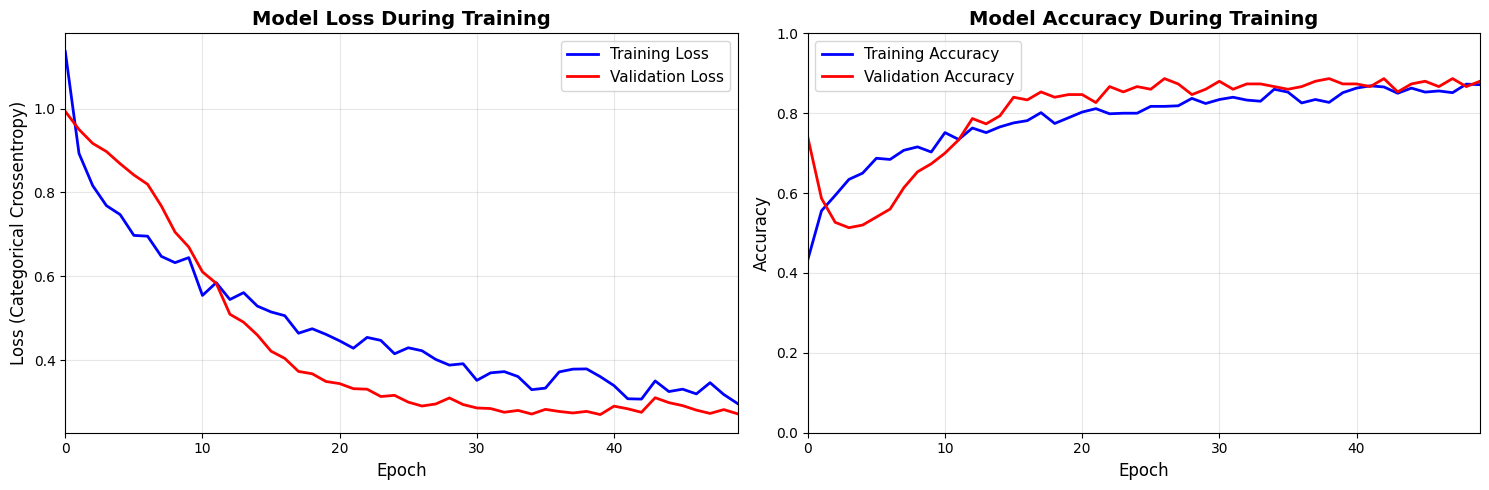

In [ ]:
# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
ax1.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (Categorical Crossentropy)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, len(history.history['loss'])-1)

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
ax2.set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, len(history.history['accuracy'])-1)
ax2.set_ylim(0, 1)

# Add final metrics as text
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]


plt.tight_layout()
plt.show()

### Predicting the test set

---
<font color=green>Q7:</font> <br><font color='green'>
Create a heatmap to visualize the predicted class probabilities for each test sample from the trained classification model.
</font>

---


In [ ]:
# Get predictions from the test set
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test_int

# Define class names
class_names = ['Long', 'Neutral', 'Short']
colors = ['green', 'gray', 'red']

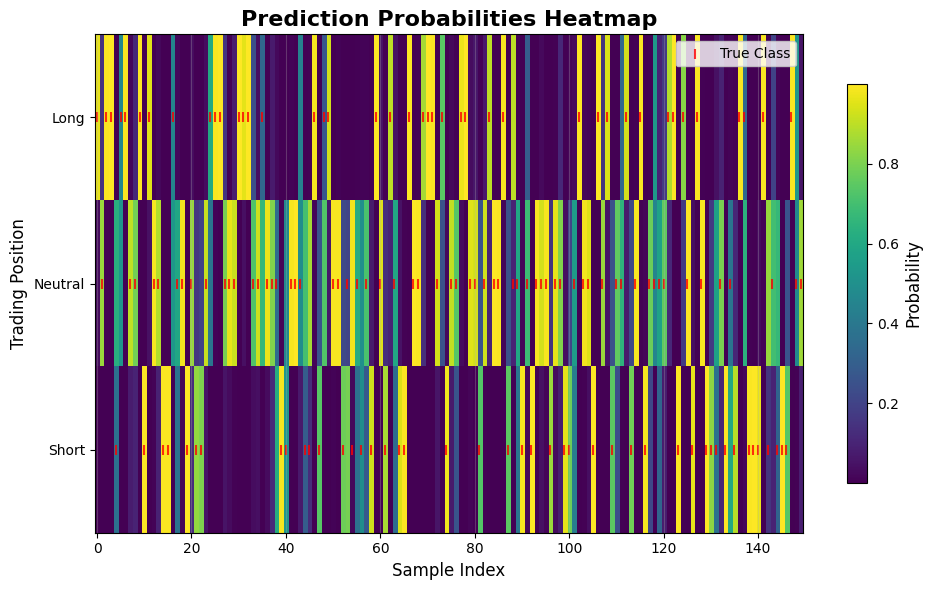

In [ ]:
plt.figure(figsize=(10, 6))

# Create heatmap of probabilities
# Transpose to have classes as rows and samples as columns
prob_heatmap = y_pred_probs.T

# Create the heatmap
im = plt.imshow(prob_heatmap, cmap='viridis', aspect='auto', interpolation='nearest')

# Set labels and title
plt.title('Prediction Probabilities Heatmap',
          fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Trading Position', fontsize=12)

# Set y-axis ticks and labels
plt.yticks([0, 1, 2], class_names)

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Probability', fontsize=12)

# Add grid lines for better readability
plt.grid(True, alpha=0.3, axis='x')

# Add sample markers for true classes (every 10th sample to avoid cluttering)
sample_step = max(1, len(y_true_classes) // 100)  # Show markers for ~100 samples max
for i in range(0, len(y_true_classes), sample_step):
    true_class = y_true_classes[i]
    plt.scatter(i, true_class, marker='|', color='red', s=50, alpha=0.8)

# Add legend for markers
plt.scatter([], [], marker='|', color='red', s=50, alpha=0.8, label='True Class')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

---
<font color=green>Q8:</font> <br><font color='green'>
Plot a time series comparison of the true class labels and predicted class labels for each test sample.
</font>

---


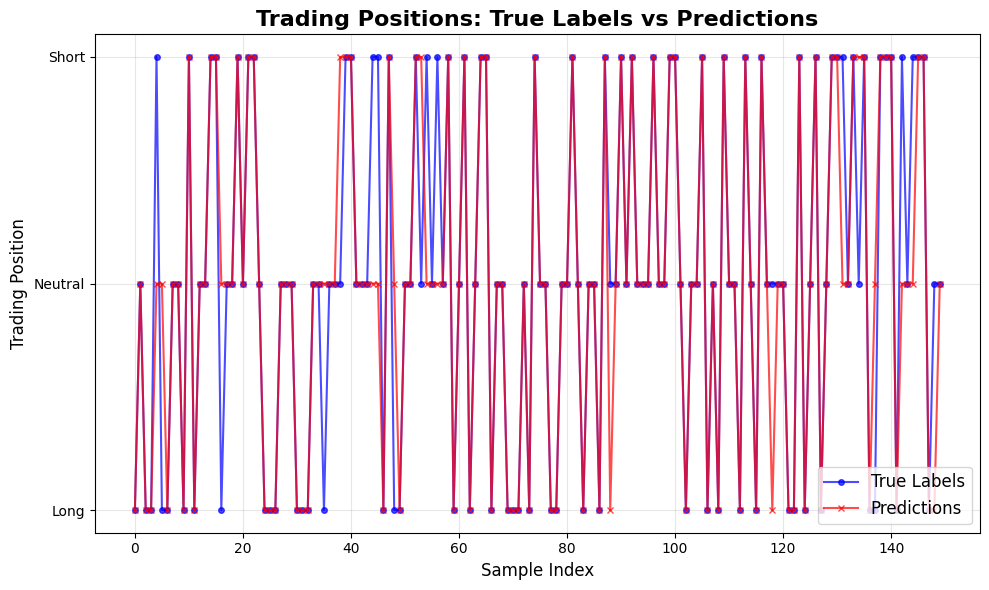

In [ ]:
plt.figure(figsize=(10, 6))

# Time series plot - single plot as requested
sample_indices = range(len(y_true_classes))

# Plot true labels and predictions
plt.plot(sample_indices, y_true_classes, 'bo-', alpha=0.7, markersize=4,
         linewidth=1.5, label='True Labels')
plt.plot(sample_indices, y_pred_classes, 'rx-', alpha=0.7, markersize=4,
         linewidth=1.5, label='Predictions')

plt.title('Trading Positions: True Labels vs Predictions',
          fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Trading Position', fontsize=12)
plt.yticks([0, 1, 2], class_names)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# The Transformer Architecture

## Scaled Dot Product Attention

### Creating a contextual embedding with Self Attention

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1Wr7AWNqXG9JWgTGJH8TrKM_2DvupWvBU"></center>

Let us consider a sequence of $D$-dimensional input vectors $(X^t)_{1 \leq t \leq T}$. In order to use the attention mechanism, we define the projections of the embeddings $X^t$ onto the $d_q$-dimensional query space, $d_k$-dimensional key space and $d_v$-dimensional value space:


\begin{align*}
     q^t &= W_Q^T X^t \in  \mathbb{R}^{d_q}  \\
    k^t &= W_K^T X^t \in  \mathbb{R}^{d_k}\\
    v^t &= W_V^T X^t \in \mathbb{R}^{d_v} \\
\end{align*}

Where $W_Q \in \mathbb{R}^{D \times d_q}$, $W_K \in \mathbb{R}^{D \times d_k}$ and $W_V \in \mathbb{R}^{D \times d_v}$ are the projection matrices onto the low dimensional query, key and value spaces, respectively. We also need $d_q = d_k$.



Let us consider a query $q^t \in \{q^1, \dots, q^{T}\}$. The Self Attention transformation, represented in figure \ref{fig:Self_Attention} consists in creating a contextual embedding $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$ associated with the embedding vector $X^t$.



To that end, the scaled dot product alignment function \cite{vaswani2017attention} is used to calculate the similarity $e^{<t, t'>}$ between the query $q^t$ and the keys $(k^{t'})_{1 \leq t' \leq T}$ as follows:

\begin{equation}
    e^{<t, t'>} = \frac{q^{t}.k^{t'}}{\sqrt{d_k}}
\end{equation}

A Softmax distribution function is then used to turn the similarity scores $e^{<t, t'>}$ into attention weights $\alpha^{<t, t'>}$ representing the contribution of the embedding $X^{t'}$ in the process of generating the contextual embedding $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$.

\begin{equation}
    \alpha^{<t, t'>} = \frac{e^{<t, t'>}}{\sum\limits_{s=1}^T e^{<t, s>}}
\end{equation}

The contextual embedding $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$ can then be computed as follows:

\begin{equation}
    A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right) = \sum\limits_{t'=1}^T \alpha^{<t, t'>} v^{t'}
\end{equation}





### The Matrix of contextual embeddings

We can generalize the way to create the contextual embedding $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$ associated with the embedding $X^t$ to all the embedding vectors $(X^{t'})_{1 \leq t' \leq T}$.


We consider the following matrix notations:


\begin{equation*}
Q =    
\begin{bmatrix}
    \text{---} & q^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & q^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d_q}, \quad
K =    
\begin{bmatrix}
    \text{---} & k^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & k^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d_k}, \quad
V =    
\begin{bmatrix}
    \text{---} & v^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & v^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d_v}
\end{equation*}


We define the scaled dot product attention matrix, denoted $A(Q, K, V)$, as follows:

\begin{equation*}
    A(Q, K, V) := \text{Softmax}\left(\frac{Q K^T}{\sqrt{d_k}} \right) V
\end{equation*}

Where the notation $\text{Softmax}(M)$ for a matrix $ M \in \mathbb{R}^{T \times d}$ refers to the Softmax applied to each row of the matrix $M$.

We have:


\begin{equation*}
    A(Q, K, V) = \begin{bmatrix}
    \text{---} & A\left(q^1, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right) & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right) & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & A\left(q^T, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right) & \text{---} \\
    \end{bmatrix}
\end{equation*}


In other words, the $t$-th row of the scaled dot product attention matrix $A(Q, K, V)$ is the contextual embedding vectors $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$ associated with the embedding vector $X^t$.

In [ ]:
# Scaled_dot_product_attention
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead)
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(k.shape[-1], dtype=tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (1-mask)*(-1.0e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)


    return output, attention_weights


### Test the scaled_dot_product_attention function

In [ ]:
# Create random data
batch_size = 32
seq_len = 10
depth_q = 64
depth_k = depth_q
depth_v = 32

q = tf.random.uniform((batch_size, seq_len, depth_q))  # (32, 10, 64)
k = tf.random.uniform((batch_size, seq_len, depth_k))  # (32, 10, 64)
v = tf.random.uniform((batch_size, seq_len, depth_v))  # (32, 10, 32)

# Call the function
output, attention_weights = scaled_dot_product_attention(q, k, v)

print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: (32, 10, 32)
Attention weights shape: (32, 10, 10)


### Visualize the Attention Weights for the first sample

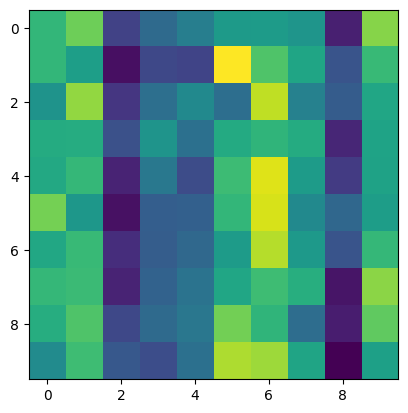

In [ ]:
# Visualize the alignment matrix for the first sample and first head
plt.imshow(attention_weights[0].numpy())

In [ ]:
attention_weights[0].shape

TensorShape([10, 10])

In [ ]:
assert tf.reduce_mean(tf.reduce_sum(attention_weights[0], axis=1)) == 1, "The attention weights don't sum to one"

### Adding a mask

In order to avoid look-ahead bias we introduce the notion of mask. Consider the following queries, keys and values:
    
\begin{equation*}
Q =    
\begin{bmatrix}
    \text{---} & q^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & q^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d}, \quad
K =    
\begin{bmatrix}
    \text{---} & k^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & k^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d}, \quad
V =    
\begin{bmatrix}
    \text{---} & v^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & v^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d}
\end{equation*}


For $t \in \{1, \dots, T \}$, we don't want the contextual embedding associated with the query $q^{t}$ to depend on the pairs $(k_{t'}, v_{t'})_{t \leq t' \leq T}$

Hence, we "mask" the contributions $\alpha^{<t, t'>}$ for all $t' > t$ by setting them to zero.

So, we set $e^{<t, t'>}$ to $- \infty$ for all $t' > t$ as shown in the following table:  


<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1xgvMf5vGaenUVvyLEsnUU4FF68On12ao"></center>


After applying the softmax, we get the masked attention weights:

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1JGyr6iVG7B7psxR7MviarVWZDrqhk8ch"></center>

In [ ]:
def create_look_ahead_mask(sequence_length):
    """
    Returns an upper triangular matrix filled with ones

    Arguments:
        sequence_length -- matrix size

    Returns:
        mask -- (1, size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

In [ ]:
# Create random data
batch_size = 32
seq_len = 10
depth_q = 64
depth_k = depth_q
depth_v = 32

q = tf.random.uniform((batch_size, seq_len, depth_q))  # (32, 10, 64)
k = tf.random.uniform((batch_size, seq_len, depth_k))  # (32, 10, 64)
v = tf.random.uniform((batch_size, seq_len, depth_v))  # (32, 10, 32)

# Call the function
output, attention_weights = scaled_dot_product_attention(q, k, v, mask=create_look_ahead_mask(seq_len))

print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: (32, 10, 32)
Attention weights shape: (32, 10, 10)


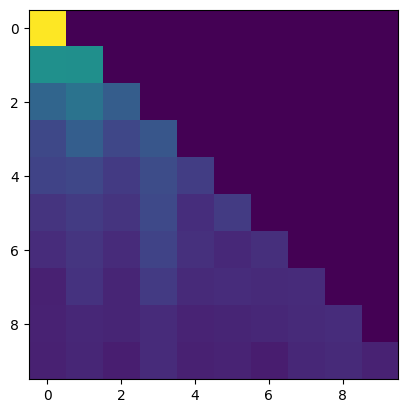

In [ ]:
# Visualize the alignment matrix for the first sample
plt.imshow(attention_weights[0].numpy())

### Applying the Scaled Dot Product Attention several times

In [ ]:
# Create random data
batch_size = 32
num_heads = 8
seq_len = 10
depth_q = 64
depth_k = depth_q
depth_v = 32

q = tf.random.uniform((batch_size, num_heads, seq_len, depth_q))  # (32, 8, 10, 64)
k = tf.random.uniform((batch_size, num_heads, seq_len, depth_k))  # (32, 8, 10, 64)
v = tf.random.uniform((batch_size, num_heads, seq_len, depth_v))  # (32, 8, 10, 32)

# Call the function
output, attention_weights = scaled_dot_product_attention(q, k, v, mask=create_look_ahead_mask(seq_len))

print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: (32, 8, 10, 32)
Attention weights shape: (32, 8, 10, 10)


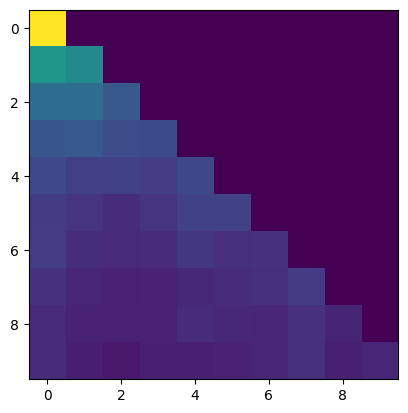

In [ ]:
# Visualize the alignment matrix for the first sample and first head
plt.imshow(attention_weights[0, 0].numpy())

## Positional Encoding

### Introducing Positional Encoding

The attention mechanism is permutation invariant. In order to account for the order of the embedding vectors $X^1, \dots, X^T \in \mathbb{R}^D$, we use positional encoding vectors.


The positional encoding vectors $p^1, \dots, p^T \in \mathbb{R}^D$ have the same dimension as the input embeddings $X^1, \dots, X^{T}$.




* For each time step $t \in \{1, \dots, T \}$, there is a unique positional encoding vector.
* The distance between two steps should be consistent across sentences with different lengths.



The method used in the original paper [vaswani2017attention](https://arxiv.org/pdf/1706.03762.pdf) is a linear transformation $T^{(k)} \in \mathbb{R}^{D \times D}$ such that

\begin{equation*}
    T^{(k)} p^{t} = p^{t+k}
\end{equation*}
  
It is defined as follows: For $d \in \{ 1, \dots, \frac{D}{2} \}$:

\begin{equation*}
    w_i = \frac{1}{100000^{\frac{2i}{D}}} \quad \text{and} \quad \quad  p^{t} = \begin{pmatrix}
    \sin(w_1 t) \\
    \cos(w_1 t) \\
    \vdots \\
    \sin(w_d t) \\
    \cos(w_d t) \\
    \vdots \\
    \sin(w_{\frac{D}{2}} t) \\
    \cos(w_{\frac{D}{2}} t) \\
    \end{pmatrix}
\end{equation*}




We define for a $d \in \{ 1, \dots, \frac{D}{2} \}$ and for all $t \in \{1 \dots, T\}$:

\begin{equation*}
    e_d^{t} =\begin{pmatrix}
    \sin{w_d t} \\
    \cos{w_d t}
    \end{pmatrix}
\end{equation*}

Therefore,


\begin{equation*}
    p^{t} = \begin{pmatrix}
    e_1^{t} \\
    \vdots \\
    e_d^{t} \\
    \vdots \\
    e_{\frac{D}{2}}^{t}
    \end{pmatrix}
\end{equation*}


By defining:
\begin{equation*}
    \mathcal{T}^{(k)} = \begin{pmatrix}
    \Phi_1^{(k)} &  &  &  &    \\
     & \ddots &  &  &    \\
     &  & \Phi_{d}^{(k)} &  &    \\
     &  & & \ddots &    \\
     &  & &  &  \Phi_{\frac{D}{2}}^{(k)}   \\
    \end{pmatrix} \quad \text{where} \quad  \Phi_d^{(k)} = \begin{pmatrix}
    \cos(w_d k) & \sin(w_d k) \\
    - \sin(w_d k) & \cos(w_d k)
    \end{pmatrix}
\end{equation*}


We get:

\begin{align*}
     \mathcal{T}^{(k)} p^{t} &= \begin{pmatrix}
    \Phi_1^{(k)} &  &  &  &    \\
     & \ddots &  &  &    \\
     &  & \Phi_{d}^{(k)} &  &    \\
     &  & & \ddots &    \\
     &  & &  &  \Phi_{\frac{D}{2}}^{(k)}   \\
    \end{pmatrix} \begin{pmatrix}
    e_1^{t} \\
    \vdots \\
    e_d^{t} \\
    \vdots \\
    e_{\frac{D}{2}}^{t}
    \end{pmatrix} \\
    &= \begin{pmatrix}
    \Phi_1^{(k)}  e_1^{t} \\
    \vdots \\
    \Phi_d^{(k)}  e_d^{t} \\
    \vdots \\
    \Phi_{\frac{D}{2}}^{(k)}  e_{\frac{D}{2}}^{t} \\
    \end{pmatrix}
\end{align*}


We have for all d in $\{ 1, \dots, \frac{D}{2} \}$:

\begin{align*}
    \Phi_d^{(k)}  e_d^{t} &= \begin{pmatrix}
    \cos(w_d k) & \sin(w_d k) \\
    - \sin(w_d k) & \cos(w_d k)
    \end{pmatrix}  \begin{pmatrix}
    \sin{w_d t} \\
    \cos{w_d t}
    \end{pmatrix} \\
    &= \begin{pmatrix}
    \cos(w_d k)  \sin{w_d t} +  \sin(w_d k)  \cos{w_d t} \\
     - \sin(w_d k) \sin{w_d t} + \cos(w_d k)  \cos{w_d t}
    \end{pmatrix} \\
    &= \begin{pmatrix}
    \sin \left( w_d (t + k) \right)  \\
    \cos \left( w_d (t + k) \right)  \\
    \end{pmatrix} \\
    &= e_d^{t+k}
\end{align*}


Therefore,

\begin{equation*}
     \mathcal{T}^{(k)} p^{t} = \begin{pmatrix}
    \Phi_1^{(k)}  e_1^{t} \\
    \vdots \\
    \Phi_d^{(k)}  e_d^{t} \\
    \vdots \\
    \Phi_{\frac{D}{2}}^{(k)}  e_{\frac{D}{2}}^{t} \\
    \end{pmatrix}
    =  \begin{pmatrix}
     e_1^{t+k} \\
    \vdots \\
     e_d^{t+k} \\
    \vdots \\
     e_{\frac{D}{2}}^{t+k} \\
    \end{pmatrix} = p^{t+k}
\end{equation*}


### Coding Positional Encoding

In [ ]:
def get_angles(positions, dimensions, D):
    """
    Get the angles of the positional embeddings

    Parameters
    ----------
    positions (T, 1) -- the positions for each
    dimensions (1, D) -- the dimensions
    D (int) -- Size of the embedding

    Returns
    -------
    (T, D) the angles of the positional embeddings

    """
    return positions/(10000**(2 * ((dimensions//2)/D)))


In [ ]:
def positional_encoding(T, D):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        T (int) -- Maximum number of positions to be encoded
        D (int) -- Encoding size

    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles
    angle_rads = get_angles(np.arange(T)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)

    # apply sin to even indices in the array; 2i
    # use: example array[start::pas] (like range(10)[3::2]) ->   [3, 5, 7, 9]
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

### Visualizing positional encoding

(1, 200, 512)


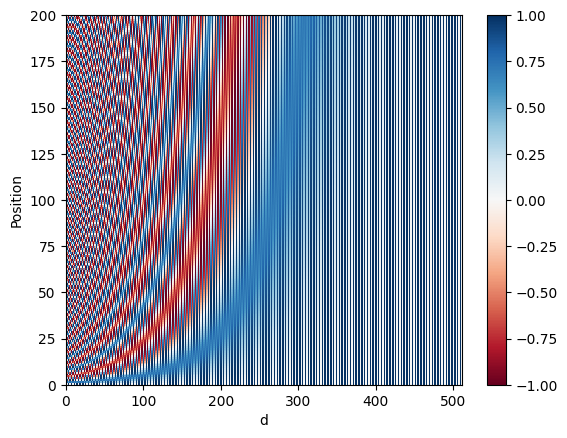

In [ ]:
pos_encoding = positional_encoding(200, 512)

print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## MultiHead Attention

### MultiHead Attention with the Scaled Dot Product Attention

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=13qvu8DouCrOjL4-Rn1-xRkaq6AoH7pB_"></center>

The scaled dot product attention can be generalized to any query $Q \in \mathbb{R}^{T_q \times d_q}$, key $K  \in \mathbb{R}^{T_k \times d_k} $ and value $V \in \mathbb{R}^{T_v \times d_v}$ matrices such that $d_q=d_k$ and $T_k = T_v = T'$.

\begin{equation*}
Q =    
\begin{bmatrix}
    \text{---} & q^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & q^{T_q} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T_q \times d_q}, \quad
K =    
\begin{bmatrix}
    \text{---} & k^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & k^{T_k} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T_k \times d_k}, \quad
V =    
\begin{bmatrix}
    \text{---} & v^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & v^{T_v} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T_v \times d_v}
\end{equation*}

The scaled dot product attention matrix is then defined as follows:

\begin{equation*}
    A(Q, K, V) = \text{Softmax}\left(\frac{Q K^T}{\sqrt{d_k}} \right) V = \begin{bmatrix}
    \text{---} & A\left(q^1, (k^{t'})_{1 \leq t' \leq T'}, (v^{t'})_{1 \leq t' \leq T'}\right) & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & A\left(q^t, (k^{t'})_{1 \leq t' \leq T'}, (v^{t'})_{1 \leq t' \leq T'}\right) & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & A\left(q^{T_q}, (k^{t'})_{1 \leq t' \leq T'}, (v^{t'})_{1 \leq t' \leq T'}\right) & \text{---} \\
    \end{bmatrix} \in \mathbb{R}^{T_q \times d_v}
\end{equation*}

The MultiHead Attention module, represented in figure \ref{fig:MHA}, consists in applying the attention mechanism defined in the previous section $h$ times in order to capture different notions of similarity.


Hence, for each head $h' \in \{1 \dots, h\}$, let $W_Q^{h'} \in \mathbb{R}^{d_q \times p_q}$, $W_K^{h'} \in \mathbb{R}^{d_k \times p_k}$ and $W_V^{h'} \in \mathbb{R}^{d_v \times p_v}$ be the $h'$-th projection matrices of $Q$, $K$ and $V$  onto the low dimensional key, query and value spaces of size $p_q$, $p_k$ and $p_v$, respectively. (We also have $p_q= p_k$).

The $h'$-th attention head is then defined as $A\left(Q W_Q^{h'}, K W_K^{h'}, V W_V^{h'} \right)$.


The concatenation layer aims at stacking all the attention heads together to make a new flatten vector, which is then projected onto $\mathbb{R}^{p_o}$ using the projection matrix $W_o \in \mathbb{R}^{h p_v \times p_o}$. The output of the MultiHead Attention layer $P$ is then computed as follows:


\begin{align*}
    P = \text{concat} \left( A\left(Q W_Q^{1}, K W_K^{1}, V W_V^{1} \right), \dots, A\left(Q W_Q^{h}, K W_K^{h}, V W_V^{h} \right) \right) W_o \in \mathbb{R}^{T_q \times p_o}
\end{align*}




### Coding MultiHead Attention Layer

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model



        if  self.d_model % self.num_heads != 0:
            raise Exception("The output dimension should be a multiple of the number of heads")

        self.d = self.d_model // self.num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.wo = Dense(d_model)

    def TransposeReshape(self, x):
        batch_size = x.shape[0]
        return tf.transpose(tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.d)), perm=[0,2,1,3])


    def call(self, q, k, v, mask=None):
        # Projection of q(N, T_Q, d_Q), k(N, T_K, d_K), v(N, T_V, d_V)
        q = self.wq(q) # (N, T_Q, d_model)
        k = self.wk(k) # (N, T_K, d_model)
        v = self.wv(v) # (N, T_V, d_model)

        # Reshape and Transpose q,k and v: (N, T_*, d_model) -> (N, h, T_*, d)
        q = self.TransposeReshape(q)
        k = self.TransposeReshape(k)
        v = self.TransposeReshape(v)

        # Apply Scaled Dot Producat Attention to q, k, v, mask -> scaled_attention, attention_weights
        # attention_output (N, h, T_Q, d)
        # attention_weights (N, h, T_Q, T_K)
        attention_output, attention_weights = scaled_dot_product_attention(q, k, v, mask=mask)

        # Transpose attention_output (N, h, T_Q, d) -> (N, T_Q, h, d)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])

        # Concat the last 2 dimensions (N, T_Q, h, d) -> (N, T_Q, d_model)
        attention_output = tf.reshape(attention_output, shape=(q.shape[0], -1, self.d_model))

        # Projection onto wo
        attention_output = self.wo(attention_output)

        # return attention_output (N, T_Q, d_model) and attention_weights (N, h, T_Q, T_K)
        return attention_output, attention_weights

### Test the MHA Layer

In [ ]:
# Hyperparameters
batch_size = 32
seq_len = 10
d_model = 64
num_heads = 8

# Create random data
q = tf.random.uniform((batch_size, seq_len, d_model))  # (32, 10, 64)
k = tf.random.uniform((batch_size, seq_len, d_model))  # (32, 10, 64)
v = tf.random.uniform((batch_size, seq_len, d_model))  # (32, 10, 64)

# Instantiate the MultiHeadAttention object
mha = MultiHeadAttention(num_heads, d_model)

# Call the object with the random data
output, attention_weights = mha(q, k, v, mask=create_look_ahead_mask(seq_len))

print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: (32, 10, 64)
Attention weights shape: (32, 8, 10, 10)


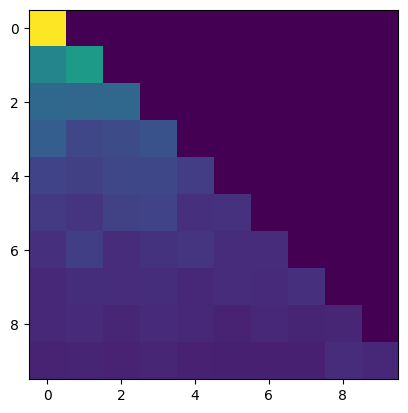

In [ ]:
# Visualize the alignment matrix for the first sample and first head
plt.imshow(attention_weights[0, 0].numpy())

### Contact

If you have any question regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk